## Network Analysis of Shakespeare and Company and Goodreads

In [18]:
# import functions from graph.py
from graph import get_goodreads_graph, get_sc_graph
from core_periphery_sbm import core_periphery as cp
import networkx as nx
from collections import Counter
import operator
import pandas as pd

In [19]:
# get vertex lists, edge weights, vertex to neighbors, and number of nodes
sc_books_in_vertex_order, sc_book_to_vertex_index, sc_edge_to_weight, sc_vertex_to_neighbors, sc_n, sc_book_uri_to_num_events, sc_book_uri_to_text, book_uri_to_year, book_uri_to_title, book_uri_to_author = get_sc_graph()

In [20]:
def print_graph_summary(books_in_vertex_order, book_to_vertex_index, edge_to_weight, vertex_to_neighbors, n):
    print('# of vertices: {:,}'.format(n))
    # all edges are included twice because these are undirected graphs
    print('# of unique edges: {:,}'.format(int(len(edge_to_weight)/2)))
    print('Total edge weights: {:,}'.format(int(sum(edge_to_weight.values())/2)))

    # list the five vertices with highest degree
    print('\nFive books with the most neighbors:')
    vertex_to_degree = {v: len(neighbors) for v, neighbors in vertex_to_neighbors.items()}
    vertex_to_degree_sorted = sorted(vertex_to_degree.items(), reverse=True, key=operator.itemgetter(1))
    for vertex_idx, degree in vertex_to_degree_sorted[:5]:
        vertex_book_name = books_in_vertex_order[vertex_idx]
        print('{} neighbors: {}'.format(degree, vertex_book_name))

In [21]:
print_graph_summary(sc_books_in_vertex_order, sc_book_to_vertex_index, sc_edge_to_weight, sc_vertex_to_neighbors, sc_n)

# of vertices: 1,511
# of unique edges: 198,115
Total edge weights: 267,207

Five books with the most neighbors:
926 neighbors: The Sun Also Rises by Hemingway, Ernest (1926)
915 neighbors: A Portrait of the Artist as a Young Man by Joyce, James (1916)
898 neighbors: Dubliners by Joyce, James (1914)
881 neighbors: Pointed Roofs (Pilgrimage 1) by Richardson, Dorothy M. (1915)
872 neighbors: A Farewell to Arms by Hemingway, Ernest (1929)


In [10]:
def tuple_to_list(edge_to_weight):
    fill = []
    for i in edge_to_weight.items():
        l = list(i)
        fill.append(l)
    edge_to_weight_list = []
    for i in fill:
        edges = i[0]
        listed_edge = list(edges)
        listed_edge.append(i[1])
        edge_to_weight_list.append(listed_edge)
    return edge_to_weight_list

In [11]:
sc_weights_list = tuple_to_list(sc_edge_to_weight)

In [12]:
# from edge [0] to edge [1], the weight is [2]
sc_weights_list[0]

[1491, 0, 1]

### Shakespeare and Co Analysis

In [13]:
# Create SHAKESPEARE AND CO graph
sc_G = nx.Graph()
sc_G.add_weighted_edges_from(sc_weights_list)

Next chunk is optional: I do this only to make the results more interpretable. 

In [14]:
# optional: change vertex ids to book names
sc_dict = {value:key for key, value in sc_book_to_vertex_index.items()}
mapping = sc_dict # Dictionary from id to title

In [15]:
sc_G = nx.relabel_nodes(sc_G, mapping)

### Core-Periphery Structure

This section draws from Gallagher et al.'s ["A clarified typology of core-periphery structure in networks"](https://advances.sciencemag.org/content/7/12/eabc9800), with code available [here](https://github.com/ryanjgallagher/core_periphery_sbm). Core-periphery structure studies how networks can be divided into a core of densely interconnected nodes, which are highly connected to other core nodes, and periphery nodes that are connected only to core nodes and not each other. This paper develops/assesses two core-periphery model types: the hub-and-spoke model that divides the network into two clean blocks (core vs. periphery) and a layered model that allows for layers of periphery-ness. 

In [16]:
# Initialize hub-and-spoke model and infer structure
hubspoke = cp.HubSpokeCorePeriphery(n_gibbs=100, n_mcmc=10*len(sc_G))
hubspoke.infer(sc_G)

In [116]:
layered = cp.LayeredCorePeriphery(n_layers=4, n_gibbs=100, n_mcmc=10*len(sc_G))
layered.infer(sc_G)

In [117]:
# Get core and periphery assignments from hub-and-spoke model
node2label_hs = hubspoke.get_labels(last_n_samples=50)

# Get layer assignments from the layered model
node2label_l = layered.get_labels(last_n_samples=50)

**Create dataframes**: the goal is to get this into a nice csv with columns for book title, author, h&s cp label, layered cp label, coreness, and probability.

In [118]:
sc_hub_spoke_df = pd.DataFrame.from_dict(node2label_hs, orient='index')
sc_layered_df = pd.DataFrame.from_dict(node2label_l, orient='index')

**Core-Periphery Label:** For both models (hub-and-spoke and layered) the core is 0; for the layered model, the further away from 0 the more peripheral the node. 

In [123]:
sc_layered_probs_df = pd.DataFrame.from_dict(node2probs_l, orient='index')

**Coreness**, where the closer to 1 the more core; closer to 0 the more peripheral.

In [124]:
# Dictionary of node -> coreness
node2coreness_l = layered.get_coreness(last_n_samples=50, return_dict=True)

In [125]:
sc_layered_coreness_df = pd.DataFrame.from_dict(node2coreness_l, orient='index')

In [149]:
# all books that are especially "corey" in the layered model
most_core = []
for book, coreness in node2coreness_l.items():  # for name, age in dictionary.iteritems():  
    if coreness > .92:
        most_core.append(book)

In [150]:
most_core

['A Farewell to Arms by Hemingway, Ernest (1929)',
 'A Handful of Dust by Waugh, Evelyn (1934)',
 'A Note in Music by Lehmann, Rosamond (1930)',
 'After Many a Summer by Huxley, Aldous (1939)',
 'All This and Heaven Too by Field, Rachel (1938)',
 'An American Tragedy by Dreiser, Theodore (1925)',
 'Angel Pavement by Priestley, J. B. (1930)',
 'Antic Hay by Huxley, Aldous (1923)',
 'Babbitt by Lewis, Sinclair (1922)',
 'Bliss and Other Stories by Mansfield, Katherine (1920)',
 'Brave New World by Huxley, Aldous (1932)',
 'Buddenbrooks by Mann, Thomas (1924)',
 "Busman's Honeymoon by Sayers, Dorothy (1937)",
 'Dead Souls by Gogol, Nikolai (1842)',
 'Death of a Hero by Aldington, Richard (1929)',
 'Dodsworth by Lewis, Sinclair (1929)',
 'Dubliners by Joyce, James (1914)',
 'Dusty Answer by Lehmann, Rosamond (1927)',
 'Esther Waters by Moore, George (1894)',
 "Famine by O'Flaherty, Liam (1937)",
 'Gentlemen Prefer Blondes: The Illuminating Diary of a Professional Lady by Loos, Anita (1925)

## Save to csv

In [129]:
sc_layered_df['book_info'] = sc_layered_df.index
sc_layered_df = sc_layered_df.rename(columns={0: "layer"})
sc_hub_spoke_df['book_info'] = sc_hub_spoke_df.index
sc_hub_spoke_df = sc_hub_spoke_df.rename(columns={0: "hub_and_spoke"})
sc_layered_coreness_df['book_info'] = sc_layered_coreness_df.index
sc_layered_coreness_df = sc_layered_coreness_df.rename(columns={0: "coreness"})
full_sc_df = sc_layered_df.merge(sc_hub_spoke_df, how='inner', on='book_info').merge(sc_layered_coreness_df, how='inner', on='book_info')
full_sc_df = full_sc_df[["book_info", "hub_and_spoke", "layer", "coreness"]]
vertex_title = pd.DataFrame.from_dict(sc_dict, orient = "index")
vertex_title["vertex"] = vertex_title.index
vertex_title = vertex_title.rename(columns={0: "book_info"})
full_sc_df = full_sc_df.merge(vertex_title, how='inner', on='book_info')
full_sc_df = full_sc_df[["vertex","book_info", "layer", "hub_and_spoke", "coreness"]]

In [141]:
#full_sc_df.to_csv("shakespeare-co-core-periphery.csv")

In [32]:
#full_sc_df = pd.read_csv("shakespeare-co-core-periphery.csv")

In [34]:
Counter(full_sc_df["layer"])

Counter({2: 197, 0: 231, 1: 146, 3: 371, 4: 566})

# Other metrics

### Density

In [43]:
sc_density = nx.density(sc_G)
print("Shakespeare and Co Network Density:", sc_density)

Shakespeare and Co Network Density: 0.17366245765051871


### Transitivity

In [44]:
triadic_closure = nx.transitivity(sc_G)
print("Triadic closure for S&C:", triadic_closure)

Triadic closure for S&C: 0.6160527307976547


### Diameter length 

In [45]:
# Get the largest connected component of the graph
components = nx.connected_components(sc_G)
largest_component = max(components, key=len)

# Create a "subgraph" of the largest component and find diameter
subgraph = sc_G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of Shakespeare and Co's largest component:", diameter)

Network diameter of Shakespeare and Co's largest component: 5


### Centrality Measures
There are multiple ways to assess centrality in a network. Centrality measures usually try to capture something similar to significance or importance in a network--but there are different ways to understand importance. This code looks at the following:
- **degree centrality:** the sum of all of a node's edges. When considering S&C, a book with the highest number of degrees demonstrates that it was the book most often read with other books in the network. This is a measure of a type of popularity (*but remember -> this isn't the book checked out the most times, it's the book checked out the most times with any other book*).  
- **betweeness centrality:** betweenness centrality disregards node degree, and instead focuses on path length for determining the most important nodes. This looks at shortest paths to figure out which nodes connect otherwise disparate parts of the network. 
- **eigenvector centrality:** eigenvector centrality accounts for whether or not a node is connected to many other high-degree nodes--this would make it a hub, and also accounts for a central node that may not have the highest # of degrees, but is highly important, regardless

In [46]:
# degree centrality
sc_degree_dict = dict(sc_G.degree(sc_G.nodes()))
nx.set_node_attributes(sc_G, sc_degree_dict, 'degree')

sc_sorted_degree = sorted(sc_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 100 nodes by degree in S&C:")
for d in sc_sorted_degree[:20]:
    print(d)

Top 100 nodes by degree in S&C:
('The Sun Also Rises by Hemingway, Ernest (1926)', 926)
('A Portrait of the Artist as a Young Man by Joyce, James (1916)', 915)
('Dubliners by Joyce, James (1914)', 898)
('Pointed Roofs (Pilgrimage 1) by Richardson, Dorothy M. (1915)', 881)
('A Farewell to Arms by Hemingway, Ernest (1929)', 872)
('Sanctuary by Faulkner, William (1931)', 862)
('Manhattan Transfer by Dos Passos, John (1925)', 861)
('The Garden Party and Other Stories by Mansfield, Katherine (1922)', 857)
('Eyeless in Gaza by Huxley, Aldous (1936)', 856)
('To the Lighthouse by Woolf, Virginia (1927)', 853)
('Mrs. Dalloway by Woolf, Virginia (1925)', 839)
('Mr. Norris Changes Trains by Isherwood, Christopher (1935)', 836)
('The Citadel by Cronin, A. J. (1937)', 834)
('The Rains Came by Bromfield, Louis (1937)', 826)
('Exiles by Joyce, James (1918)', 822)
('An American Tragedy by Dreiser, Theodore (1925)', 821)
('The Years by Woolf, Virginia (1937)', 816)
('The Waves by Woolf, Virginia (1931)

In [47]:
sc_degree_df = pd.DataFrame.from_dict(sc_degree_dict, orient='index')
sc_degree_df["book_info"] = sc_degree_df.index

In [48]:
sc_degree_df = sc_degree_df.rename(columns={0: "degree_centrality"})

In [49]:
# betweenness centrality
betweenness_dict = nx.betweenness_centrality(sc_G) # Run betweenness centrality
# Assign each to an attribute in your network
nx.set_node_attributes(sc_G, betweenness_dict, 'betweenness')

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 S&C nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 S&C nodes by betweenness centrality:
('A Portrait of the Artist as a Young Man by Joyce, James (1916)', 0.014924835032906583)
('Dubliners by Joyce, James (1914)', 0.010156046367298105)
('Pointed Roofs (Pilgrimage 1) by Richardson, Dorothy M. (1915)', 0.008879411450326712)
('Mr. Norris Changes Trains by Isherwood, Christopher (1935)', 0.00883794691974864)
('The Sun Also Rises by Hemingway, Ernest (1926)', 0.008235339008884771)
('Moby-Dick; Or, the Whale by Melville, Herman (1851)', 0.008034408237163468)
('The Garden Party and Other Stories by Mansfield, Katherine (1922)', 0.008031697753147465)
('Exiles by Joyce, James (1918)', 0.00738764971447236)
('Manhattan Transfer by Dos Passos, John (1925)', 0.007156264192218229)
('Sister Carrie by Dreiser, Theodore (1900)', 0.006408263758941081)
('Bliss and Other Stories by Mansfield, Katherine (1920)', 0.006177860270808386)
('The Way of All Flesh by Butler, Samuel (1903)', 0.006108800015310316)
('Of Human Bondage by Maugham, W. Somerset (1

In [50]:
sc_between_df = pd.DataFrame.from_dict(betweenness_dict, orient='index')
sc_between_df["book_info"] = sc_between_df.index

sc_between_df = sc_between_df.rename(columns={0: "between_centrality"})

In [51]:
# eigenvector centrality
eigenvector_dict = nx.eigenvector_centrality(sc_G) # Run eigenvector centrality
nx.set_node_attributes(sc_G, eigenvector_dict, 'eigenvector')

sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 S&C nodes by eigenvector centrality:")
for b in sorted_eigenvector[:20]:
    print(b)

Top 20 S&C nodes by eigenvector centrality:
('The Sun Also Rises by Hemingway, Ernest (1926)', 0.055801125995367726)
('Eyeless in Gaza by Huxley, Aldous (1936)', 0.05548865989154352)
('Mrs. Dalloway by Woolf, Virginia (1925)', 0.05516511583917018)
('A Farewell to Arms by Hemingway, Ernest (1929)', 0.055121774229754)
('To the Lighthouse by Woolf, Virginia (1927)', 0.054963118299115946)
('Sanctuary by Faulkner, William (1931)', 0.05472684041384402)
('The Citadel by Cronin, A. J. (1937)', 0.054447706240786826)
('Sparkenbroke by Morgan, Charles (1936)', 0.054380357944984005)
("Axel's Castle: A Study in the Imaginative Literature of 1870 – 1930 by Wilson, Edmund (1931)", 0.054352362709488754)
('The Death of the Heart by Bowen, Elizabeth (1938)', 0.05426823855787121)
('The Waves by Woolf, Virginia (1931)', 0.05420492470624962)
('The Rains Came by Bromfield, Louis (1937)', 0.05416759259919326)
('An American Tragedy by Dreiser, Theodore (1925)', 0.05413418327159532)
('Manhattan Transfer by Dos

In [52]:
sc_eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient='index')
sc_eigenvector_df["book_info"] = sc_eigenvector_df.index

In [53]:
sc_eigenvector_df = sc_eigenvector_df.rename(columns={0: "eigenvector_centrality"})

### Combine all

In [142]:
full_sc_df = full_sc_df.merge(sc_degree_df, how='inner', on='book_info').merge(sc_between_df, how='inner', on='book_info').merge(sc_eigenvector_df, how='inner', on='book_info')

In [143]:
full_sc_df.head(10)

,vertex,book_info,layer,hub_and_spoke,coreness,degree_centrality,between_centrality,eigenvector_centrality
0,1292,"1914 and Other Poems by Brooke, Rupert (1915)",3,1,0.026667,9,0.000000,0.000335
1,966,"1919 by Dos Passos, John (1932)",0,0,0.913333,627,0.001662,0.045174
2,128,"A Backward Glance by Wharton, Edith (1934)",2,1,0.340000,235,0.000264,0.015205
3,1044,"A Book of Nonsense by Lear, Edward (1846)",3,1,0.006667,13,0.000000,0.000778
4,1088,"A Child's Garden of Verses by Stevenson, Rober...",2,1,0.253333,119,0.000000,0.007940
5,175,"A Christmas Garland by Beerbohm, Max (1912)",3,1,0.026667,97,0.000031,0.006165
6,914,"A City of Bells by Goudge, Elizabeth (1936)",1,0,0.620000,336,0.000219,0.026609
7,286,A Connecticut Yankee in King Arthur's Court by...,3,1,0.000000,11,0.000000,0.000819
8,841,"A Crystal Age by Hudson, W. H. (1887)",2,1,0.320000,188,0.000135,0.011854
9,322,"A Daughter of the Samurai by Sugimoto, Etsuko ...",1,0,0.646667,391,0.000215,0.030789


In [144]:
full_sc_df.to_csv("shakespeare-co-core-periphery.csv")

## Top Users

In [56]:
sc_file = 'shakespeare-co-core-periphery.csv'

In [58]:
sc_df = pd.read_csv(sc_file)

In [59]:
uri_to_text = pd.DataFrame.from_dict(sc_book_uri_to_text, orient = "index").reset_index()
uri_to_text = uri_to_text.rename(columns = {"index":"uri", 0: "sc_info"})

In [60]:
uri_to_text

,uri,sc_info
0,https://shakespeareandco.princeton.edu/books/m...,"Le Morte d'Arthur by Malory, Thomas (1485)"
1,https://shakespeareandco.princeton.edu/books/m...,"Utopia by More, Thomas (1516)"
2,https://shakespeareandco.princeton.edu/books/n...,"Gorboduc by Norton, Thomas (1561)"
3,https://shakespeareandco.princeton.edu/books/l...,"Euphues: The Anatomy of Wit by Lyly, John (1578)"
4,https://shakespeareandco.princeton.edu/books/s...,"The Shepheard's Calendar by Spenser, Edmund (1..."
...,...,...
6013,https://shakespeareandco.princeton.edu/books/u...,[unclear]ile
6014,https://shakespeareandco.princeton.edu/books/u...,[unclear]ism
6015,https://shakespeareandco.princeton.edu/books/u...,[unclear]y
6016,https://shakespeareandco.princeton.edu/books/u...,[unidentified Benn’s Library]


In [76]:
new_df = sc_df.merge(uri_to_text, left_on = "book_info", right_on = "sc_info")

In [109]:
sc_borrower_to_books = get_sc_borrower_to_books()

killen = 'https://shakespeareandco.princeton.edu/members/killen/'
raphael = 'https://shakespeareandco.princeton.edu/members/raphael-france/'
de_marcilly = 'https://shakespeareandco.princeton.edu/members/marcilly/'

killen_books = sc_borrower_to_books[killen]
raphael_books = sc_borrower_to_books[raphael]
de_marcilly_books = sc_borrower_to_books[de_marcilly]

In [80]:
killen_df = pd.DataFrame.from_dict(killen_books)

In [81]:
killen_df["killen"] = 1
killen_df = killen_df.rename(columns={0:"uri"})

In [82]:
killen_df.sample(5)

,uri,killen
13,https://shakespeareandco.princeton.edu/books/r...,1
174,https://shakespeareandco.princeton.edu/books/f...,1
216,https://shakespeareandco.princeton.edu/books/b...,1
124,https://shakespeareandco.princeton.edu/books/w...,1
138,https://shakespeareandco.princeton.edu/books/c...,1


In [83]:
raphael_df = pd.DataFrame.from_dict(raphael_books)
raphael_df["raphael"] = 1
raphael_df = raphael_df.rename(columns={0:"uri"})
raphael_df.sample(5)

,uri,raphael
87,https://shakespeareandco.princeton.edu/books/m...,1
122,https://shakespeareandco.princeton.edu/books/m...,1
80,https://shakespeareandco.princeton.edu/books/l...,1
222,https://shakespeareandco.princeton.edu/books/c...,1
251,https://shakespeareandco.princeton.edu/books/b...,1


In [111]:
de_marcilly_df = pd.DataFrame.from_dict(de_marcilly_books)
de_marcilly_df["de_marcilly"] = 1
de_marcilly_df = de_marcilly_df.rename(columns={0:"uri"})
de_marcilly_df.shape

(169, 2)

In [112]:
new_df['de_marcilly_match'] = 0
new_df.loc[new_df['uri'].isin(de_marcilly_df['uri']), 'de_marcilly_match'] = 1

In [113]:
from collections import Counter
Counter(new_df['de_marcilly_match'])

Counter({1: 169, 0: 1342})

In [84]:
new_df['killen_match'] = 0
new_df.loc[new_df['uri'].isin(killen_df['uri']), 'killen_match'] = 1

In [85]:
from collections import Counter
Counter(new_df['killen_match'])

Counter({0: 1134, 1: 377})

In [86]:
new_df['raphael_match'] = 0
new_df.loc[new_df['uri'].isin(raphael_df['uri']), 'raphael_match'] = 1

In [87]:
Counter(new_df['raphael_match'])

Counter({1: 283, 0: 1228})

In [114]:
new_df.sample(20)

,Unnamed: 0,vertex,book_info,layer,hub_and_spoke,coreness,degree_centrality,between_centrality,eigenvector_centrality,events,Unnamed: 10,Unnamed: 11,Unnamed: 12,uri,sc_info,killen_match,raphael_match,de_marcilly_match
592,671,973,"Peking Picnic by Bridge, Ann (1932)",2,0,0.475,378,0.000319,2.933378e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/o...,"Peking Picnic by Bridge, Ann (1932)",0,1,0
244,707,1403,"Precious Bane: A Novel by Webb, Mary (1924)",2,0,0.510,512,0.001094,3.573663e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/w...,"Precious Bane: A Novel by Webb, Mary (1924)",0,1,0
1193,1477,820,"Whom God Hath Joined by Bennett, Arnold (1906)",4,1,0.070,60,0.000000,3.984067e-03,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/b...,"Whom God Hath Joined by Bennett, Arnold (1906)",0,0,0
1456,1342,118,"The Vodi by Braine, John (1959)",4,1,0.020,3,0.000000,1.230000e-07,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/b...,"The Vodi by Braine, John (1959)",0,0,0
1198,555,1373,"Men in War by Latzko, Andreas (1918)",4,1,0.055,59,0.000000,3.088599e-03,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/l...,"Men in War by Latzko, Andreas (1918)",0,0,0
256,593,573,"Murder in Mesopotamia by Christie, Agatha (1936)",2,0,0.480,490,0.001052,3.145265e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/c...,"Murder in Mesopotamia by Christie, Agatha (1936)",0,0,1
768,900,597,"The Bridge by Crane, Hart (1930)",3,1,0.225,156,0.000144,1.016877e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/c...,"The Bridge by Crane, Hart (1930)",0,0,0
810,1412,188,"Tortilla Flat by Steinbeck, John (1935)",3,1,0.225,168,0.000120,1.208701e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/s...,"Tortilla Flat by Steinbeck, John (1935)",0,0,0
508,625,1413,"Nonsense Novels by Leacock, Stephen (1920)",4,1,0.095,125,0.000417,6.747020e-03,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/l...,"Nonsense Novels by Leacock, Stephen (1920)",0,0,0
814,1415,760,Travels with a Donkey in the Cévennes by Steve...,3,1,0.250,191,0.000117,1.292122e-02,NaN,NaN,NaN,NaN,https://shakespeareandco.princeton.edu/books/s...,Travels with a Donkey in the Cévennes by Steve...,0,0,0


In [115]:
new_df.to_csv('cp-centrality-readers.csv')

In [116]:
total_num_df = pd.DataFrame.from_dict(sc_book_uri_to_num_events, orient = "index").reset_index()

In [117]:
total_num_df

,index,0
0,https://shakespeareandco.princeton.edu/books/e...,17
1,https://shakespeareandco.princeton.edu/books/h...,28
2,https://shakespeareandco.princeton.edu/books/l...,28
3,https://shakespeareandco.princeton.edu/books/m...,5
4,https://shakespeareandco.princeton.edu/books/s...,2
...,...,...
5878,https://shakespeareandco.princeton.edu/books/m...,1
5879,https://shakespeareandco.princeton.edu/books/i...,1
5880,https://shakespeareandco.princeton.edu/books/o...,1
5881,https://shakespeareandco.princeton.edu/books/b...,1


In [118]:
total_num_df.sum()

index    https://shakespeareandco.princeton.edu/books/e...
0                                                    21873
dtype: object

In [119]:
from collections import Counter
Counter(new_df['layer'])

Counter({2: 197, 0: 231, 1: 146, 3: 371, 4: 566})

In [120]:
core_books = new_df[new_df['layer'] == 0]

In [121]:
core_books.shape

(231, 18)

In [122]:
Counter(core_books["killen_match"])

Counter({1: 231})

In [123]:
Counter(core_books["raphael_match"])

Counter({0: 107, 1: 124})

In [124]:
Counter(core_books["de_marcilly_match"])

Counter({1: 57, 0: 174})

In [107]:
new_df.groupby('layer')['killen_match'].sum()

layer
0    231
1    146
2      0
3      0
4      0
Name: killen_match, dtype: int64

In [108]:
new_df.groupby('layer')['raphael_match'].sum()

layer
0    124
1     10
2    149
3      0
4      0
Name: raphael_match, dtype: int64

In [125]:
new_df.groupby('layer')['de_marcilly_match'].sum()

layer
0    57
1    32
2    45
3    35
4     0
Name: de_marcilly_match, dtype: int64

In [128]:
new_df["combined_readers"] = new_df["killen_match"] + new_df["raphael_match"]

In [129]:
Counter(new_df["combined_readers"])

Counter({1: 392, 2: 134, 0: 985})

## Correlations

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [3]:
readers_df = pd.read_csv('cp-centrality-readers.csv')

In [4]:
readers_small_df = readers_df[["coreness", "degree_centrality", "between_centrality", "eigenvector_centrality", "killen_match", "raphael_match"]]

In [5]:
# create new column with combination of killen and raphael
readers_small_df["combined_readers"] = readers_small_df["killen_match"] + readers_small_df["raphael_match"]

<ipython-input-5-57adca1be2ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readers_small_df["combined_readers"] = readers_small_df["killen_match"] + readers_small_df["raphael_match"]


In [6]:
readers_small_df = readers_small_df.rename(columns = {"coreness": "Coreness", "degree_centrality": "Degree Centrality", "between_centrality": "Betweenness Centrality", "eigenvector_centrality": "Eigenvector Centrality", "killen_match": "Killen", "raphael_match": "Raphael", "combined_readers": "Killen and Raphael"})
readers_small_df = readers_small_df[["Coreness", "Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality", "Killen and Raphael"]]

In [7]:
reader_corr = readers_small_df.corr(method='spearman')
mask = np.triu(np.ones_like(reader_corr, dtype=bool))

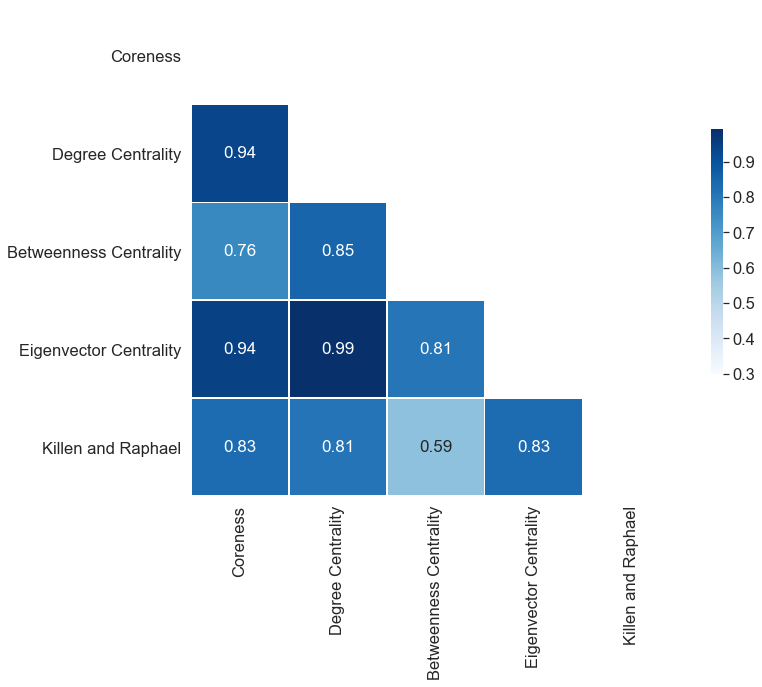

In [8]:
sns.set_theme(style="white", font_scale=1.5)
f, ax = plt.subplots(figsize=(11, 9))
sns_plot = sns.heatmap(reader_corr, mask=mask,  cmap="Blues", annot=True, vmin=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":17})

In [9]:
if not os.path.exists('./figures'):
    os.makedirs('./figures')
figure = sns_plot.get_figure()    
figure.savefig('./figures/readers_corr.png', dpi=300,bbox_inches='tight')